### 1. Set Up Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import _keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Input, Activation, Add, GlobalAveragePooling1D, AveragePooling2D
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import os
import zipfile
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import sys
print("Python Version:", sys.version)
print("Tensorflow Version", tf.__version__)

Python Version: 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
Tensorflow Version 2.10.0


### 2. Set up GPU running for Tensorflow

In [2]:
# Set up for using GPU (don't recommend if your GPU efficiency is lower than CPU)

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    # Set only the first GPU device to be visible
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    print(f"Using only GPU device {physical_devices[0].name}\n")
else:
    print("No physical GPU devices found! \n")

# Verify GPU visibility in TensorFlow
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

No physical GPU devices found! 

GPU is not available


In [3]:
# unzip dataset file
path_to_zip_file = './Furniture_Data.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall('.')
    zip_ref.close()

### 3. Handle Base Furniture Dataset
#### 3.1. Data Preparation

In [56]:
# Define the root directory where your categorical folders are located
base_data_dir = "./Furniture_Data"

# Function to get all folder names within a directory
def get_furiture_categories(directory):
    folders = []
    for item in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, item)):
            folders.append(item)
    return folders

# Function to get the number of categorical folders and the number of folders within each categorical folder
def get_category_info(root_dir):
    categorical_folders = get_furiture_categories(root_dir)
    num_categorical_folders = len(categorical_folders)
    folder_info = {}
    for cat_folder in categorical_folders:
        cat_folder_path = os.path.join(root_dir, cat_folder)
        folders_in_cat = get_furiture_categories(cat_folder_path)
        num_folders_in_cat = len(folders_in_cat)
        folder_info[cat_folder] = {
            "num_folders": num_folders_in_cat,
            "folders": folders_in_cat
        }
    return num_categorical_folders, folder_info

In [91]:
# Get the number of categorical folders and the number of folders within each categorical folder
num_classes, folder_info = get_category_info(base_data_dir)
print("Number of categorical folders:", num_classes)
print("Folder info within each categorical folder:")
for cat_folder, info in folder_info.items():
    print(f" - {cat_folder}: {info['num_folders']} folders")
    print(f"   {info['folders']}")



Number of categorical folders: 6
Folder info within each categorical folder:
 - beds: 17 folders
   ['Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian', 'Southwestern', 'Traditional', 'Transitional', 'Tropical', 'Victorian']
 - chairs: 17 folders
   ['Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian', 'Southwestern', 'Traditional', 'Transitional', 'Tropical', 'Victorian']
 - dressers: 17 folders
   ['Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian', 'Southwestern', 'Traditional', 'Transitional', 'Tropical', 'Victorian']
 - lamps: 17 folders
   ['Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandin

In [58]:
# Function to get the image paths as a dictionary
def get_image_paths_dict(root_dir):
    image_paths_dict = {}
    for cat_folder, info in folder_info.items():
        cat_image_paths = {}
        for fur_type in info['folders']:
            dir_link = os.path.join(base_data_dir, cat_folder, fur_type)
            image_paths = [os.path.join(dir_link, img_path) for img_path in os.listdir(dir_link)]
            cat_image_paths[fur_type] = image_paths
        image_paths_dict[cat_folder] = cat_image_paths
    return image_paths_dict

# Get the image paths as a dictionary
image_paths_dict = get_image_paths_dict(base_data_dir)

# Print example paths from the dictionary
for cat_folder, fur_types in image_paths_dict.items():
    for fur_type, paths in fur_types.items():
        print(f"Category: {cat_folder}, Fur type: {fur_type}")
        print("Example paths:")
        for path in paths[:3]:  # print first 3 paths for each fur type
            print(path)
        print("...")



Category: beds, Fur type: Asian
Example paths:
./Furniture_Data\beds\Asian\19726asian-daybeds.jpg
./Furniture_Data\beds\Asian\20027asian-canopy-beds.jpg
./Furniture_Data\beds\Asian\20109asian-panel-beds.jpg
...
Category: beds, Fur type: Beach
Example paths:
./Furniture_Data\beds\Beach\24547beach-style-nightstands-and-bedside-tables.jpg
./Furniture_Data\beds\Beach\2832beach-style-canopy-beds.jpg
./Furniture_Data\beds\Beach\3858beach-style-panel-beds.jpg
...
Category: beds, Fur type: Contemporary
Example paths:
./Furniture_Data\beds\Contemporary\1001contemporary-platform-beds.jpg
./Furniture_Data\beds\Contemporary\1002contemporary-bunk-beds.jpg
./Furniture_Data\beds\Contemporary\1003contemporary-adjustable-beds.jpg
...
Category: beds, Fur type: Craftsman
Example paths:
./Furniture_Data\beds\Craftsman\2638craftsman-panel-beds.jpg
./Furniture_Data\beds\Craftsman\2671craftsman-platform-beds.jpg
./Furniture_Data\beds\Craftsman\27972craftsman-daybeds.jpg
...
Category: beds, Fur type: Eclectic

In [63]:
# Convert the dictionary of image paths into a DataFrame
df_list = []

for cat_folder, fur_types in image_paths_dict.items():
    for fur_type, paths in fur_types.items():
        for path in paths:
            df_list.append({
                "Furniture_Category": cat_folder,
                "Furniture_Type": fur_type,
                "Image_Path": path
            })

# Create DataFrame from the list of dictionaries
furniture_df = pd.DataFrame(df_list)

# Print the DataFrame
print(furniture_df.head())

  Furniture_Category                                         Image_Path
0               beds  ./Furniture_Data\beds\Asian\19726asian-daybeds...
1               beds  ./Furniture_Data\beds\Asian\20027asian-canopy-...
2               beds  ./Furniture_Data\beds\Asian\20109asian-panel-b...
3               beds  ./Furniture_Data\beds\Asian\20508asian-platfor...
4               beds  ./Furniture_Data\beds\Asian\20750asian-comfort...


#### 3.2. Exploration Data Analysis (EDA)

In [64]:
furniture_df.shape

(90084, 2)

In [65]:
furniture_df['Furniture_Category'].value_counts()

Furniture_Category
lamps       32402
chairs      22053
tables      17100
dressers     7871
beds         6578
sofas        4080
Name: count, dtype: int64

<Axes: xlabel='Furniture_Category'>

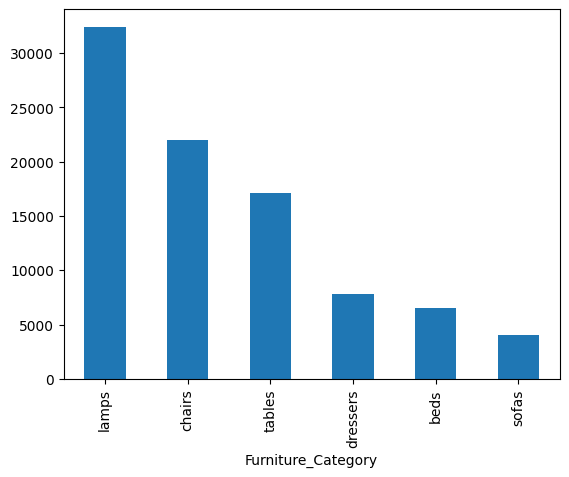

In [66]:
furniture_df['Furniture_Category'].value_counts().plot.bar()

In [67]:
furniture_df.groupby('Furniture_Category')['Furniture_Type'].value_counts()

KeyError: 'Column not found: Furniture_Type'

In [13]:
furniture_df['Furniture_Type'].value_counts()

Furniture_Type
Contemporary     17605
Traditional      16456
Transitional     14329
Modern            7184
Midcentury        6737
Industrial        5326
Farmhouse         3753
Beach             3734
Asian             3069
Craftsman         2968
Mediterranean     1974
Victorian         1848
Rustic            1839
Eclectic          1629
Tropical           855
Scandinavian       414
Southwestern       364
Name: count, dtype: int64

<Axes: xlabel='Furniture_Type'>

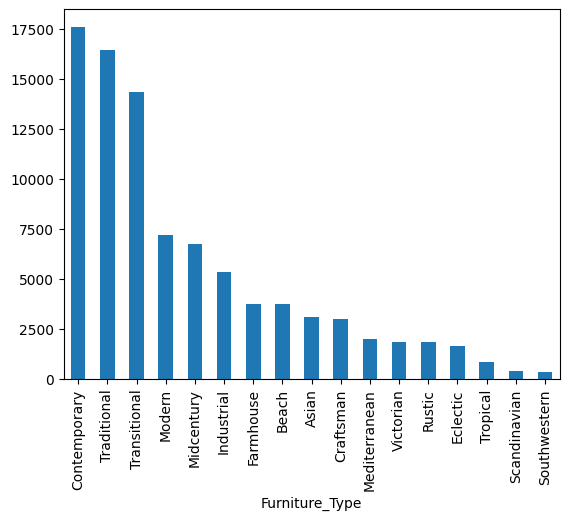

In [15]:
furniture_df['Furniture_Type'].value_counts().plot.bar()

<Axes: xlabel='Furniture_Category,Furniture_Type'>

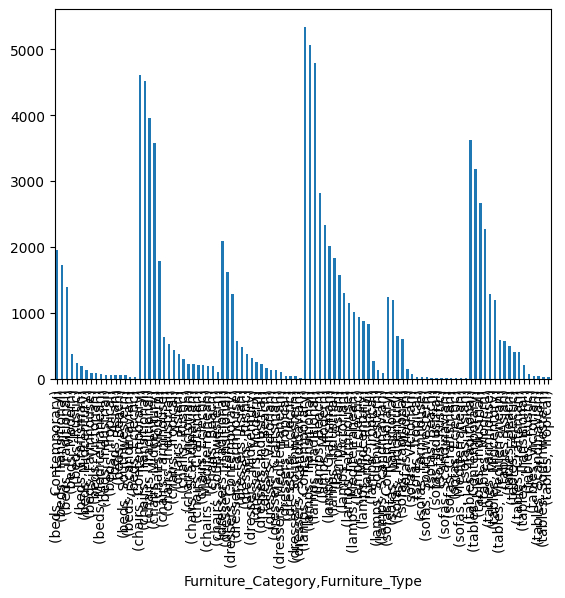

In [12]:
furniture_df.groupby('Furniture_Category')['Furniture_Type'].value_counts().plot.bar()

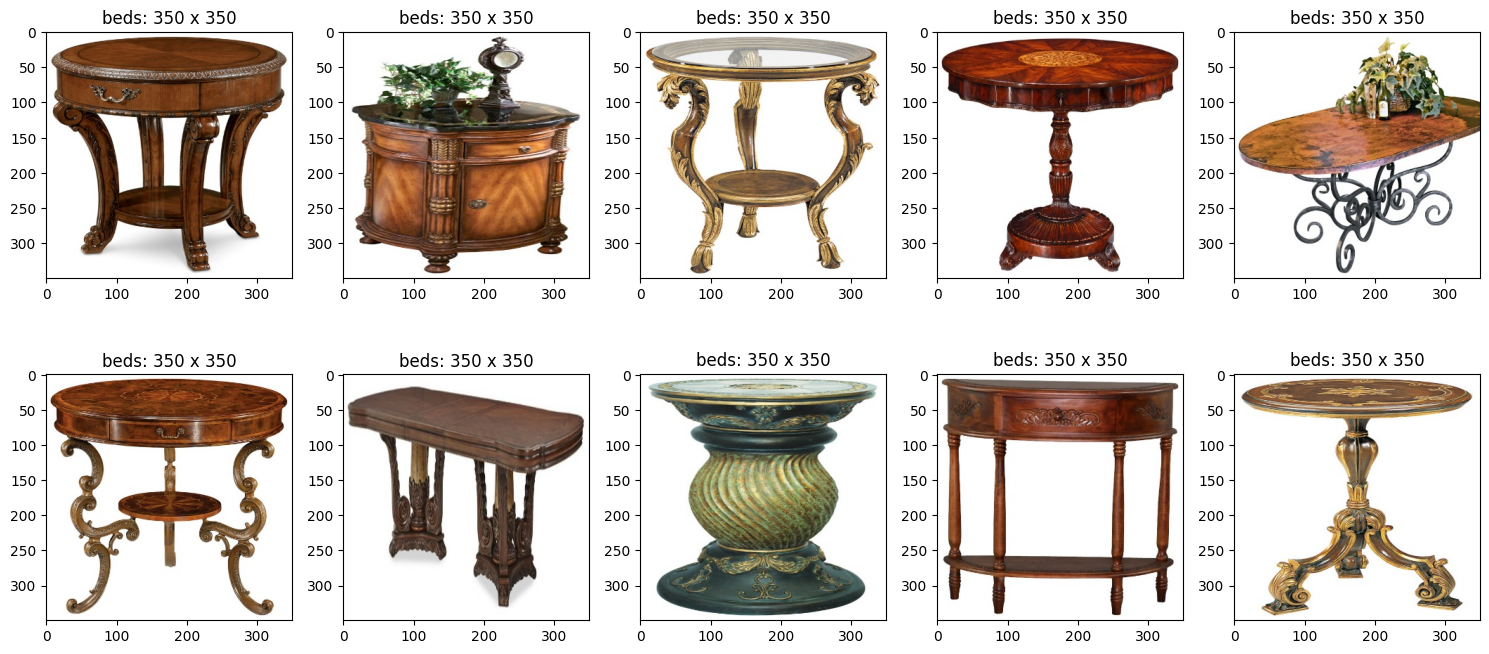

In [39]:
# Check image for image overview (contain name and size of flower images)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    image_overview = Image.open(furniture_df.loc[i, "Image_Path"])
    ax.imshow(image_overview)
    
    width, height = image_overview.size
    ax.set_title(furniture_df.loc[i, "Furniture_Category"] + ": {} x {}".format(width, height))
plt.tight_layout()
plt.show()

### 4. Handle additional data from crawling website
#### 4.1 Data Preparation

#### 4.2. Exploration Data Analysis (EDA)

### 5. Group 2 dataset into 1

### 6. Split data into train and test set and prepare for data augmentation and normalization

In [95]:
train, val = train_test_split(furniture_df,train_size=0.85, shuffle=True, random_state=333)

In [96]:
train.shape, val.shape

((76571, 2), (13513, 2))

In [97]:
#defined
BATCH_SIZE = 32

IMG_WIDTH  = 224
IMG_HEIGHT = 224

# Data Augmentation and Normalization
train_datagen = ImageDataGenerator( rescale=1/255.0,
                                    rotation_range=40,
                                    # width_shift_range=0.05,
                                    # height_shift_range=0.05,
                                    shear_range=0.2,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    # fill_mode='nearest',
                                    validation_split=0.15,                      
                                    )

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [99]:
train_ds = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Image_Path',
    y_col='Furniture_Category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_ds = test_datagen.flow_from_dataframe(
    dataframe=val,
    x_col='Image_Path',
    y_col='Furniture_Category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 76569 validated image filenames belonging to 6 classes.
Found 13513 validated image filenames.


In [100]:
print(train_ds.class_indices)

{'beds': 0, 'chairs': 1, 'dressers': 2, 'lamps': 3, 'sofas': 4, 'tables': 5}


(32, 224, 224, 3)
(32, 6)
Label:  [0. 0. 0. 1. 0. 0.]


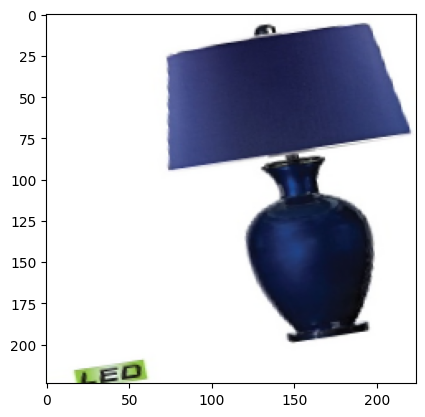

Label:  [0. 0. 0. 1. 0. 0.]


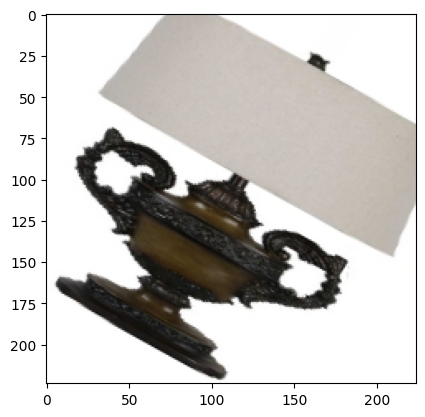

Label:  [0. 0. 0. 1. 0. 0.]


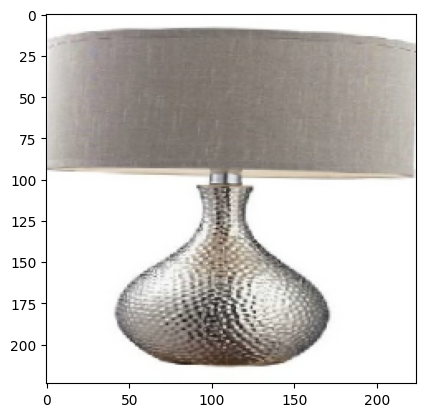

In [101]:
# Check image after data augmentation and normalization
batchX, batchY = train_ds.next()

print(batchX.shape)
print(batchY.shape)
for i in range(3):
    img = batchX[i]
    label = batchY[i]

    # print('Img: ', img)
    print('Label: ', label)

    plt.imshow(img)
    plt.show()

Model Construction Building

In [92]:
# model = Sequential([
#     Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
#     Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
#     Dropout(0.2),
#     MaxPooling2D(pool_size=(2,2), strides=(2,2)),

#     Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
#     Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
#     Dropout(0.2),
#     MaxPooling2D(pool_size=(2,2), strides=(2,2)),

#     Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
#     Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
#     Dropout(0.2),
#     MaxPooling2D(pool_size=(2,2), strides=(2,2)),

#     Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
#     Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
#     Dropout(0.2),
#     MaxPooling2D(pool_size=(2,2), strides=(2,2)),

#     Flatten(),
#     Dense(1024, activation='relu'),
#     Dense(num_classes, activation='softmax')
# ])

# model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_37 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 dropout_15 (Dropout)        (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 conv2d_39 (Conv2D)          (None, 112, 112, 32)      9248      
                                                     

In [ ]:
# AlexNet From Scratch
# Source: https://www.researchgate.net/figure/AlexNet-architecture-used-as-the-baseline-model-for-the-analysis-of-results-on-the_fig5_339756908


# model = Sequential([
#     Conv2D(64, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
#     MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid'),
    
#     Conv2D(192, kernel_size=(5,5), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid'),


#     Conv2D(384, kernel_size=(3,3), padding='valid', activation='relu'),
#     Conv2D(256, kernel_size=(3,3), padding='valid', activation='relu'),
#     Conv2D(256, kernel_size=(3,3), padding='valid', activation='relu'),

#     MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid'),

#     Flatten(),
#     Dense(units=4096, activation='relu'),
#     Dropout(0.5),
#     Dense(units=4096, activation='relu'),
#     Dropout(0.5),

#     Dense(num_classes, activation='softmax')
# ])

# model.summary()

In [102]:
model = Sequential([
    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    
    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    Flatten(),
    Dropout(0.5),
    Dense(units=64, activation='relu'),

    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 28, 28, 64)     

In [103]:
# Fine tuning for Adam and Early Stopping function
optimization = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimization, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience = 15,
    restore_best_weights = True,
    verbose = 1,
    min_delta = 0.0001,
)

# Test with Epoch of 20
history = model.fit(train_ds, validation_data=val_ds, epochs=5, batch_size=BATCH_SIZE, callbacks=[early_stopping_callback])

Epoch 1/5


In [ ]:
# Line Chart for showing loss and accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Test overall accuracy final
batchXTest, batchYTest = val_ds.next()

score = model.evaluate(batchXTest, batchYTest)

In [ ]:
# Model Structure Overview
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.save('./TrainingModels/furniture_cat_classification_model.h5')